In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd

import rasterio
from rasterio.plot import show

from shapely.geometry import Point

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_statistic as ART_sta

In [2]:
# lon_min, lon_max, lat_min, lat_max, area = 6.5, 19, 36.5, 48, 'ITALY'
lon_min, lon_max, lat_min, lat_max, area, toll = 6.55, 18.95, 36.5, 47.95, 'ITALY', 0.002

In [3]:
COMPUTERNAME = os.environ['COMPUTERNAME']
print(f'Computer: {COMPUTERNAME}')

if COMPUTERNAME == 'BR_DELL':
    dir_font = os.path.join('/','run')
else:
    dir_font = os.path.join('/')

Computer: BR_DELL


In [4]:
obs_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC')

In [5]:
NE_dir = os.path.join(dir_font,'media','arturo','T9','Data','shapes','Natural_Earth','NE_10m_LowReso','NE1_LR_LC_SR_W.tif')
naturalearth = rasterio.open(NE_dir)

In [6]:
veneto_dir = os.path.join(dir_font,'media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'DEM','Italy_dem_800.geojson'))
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

REGIONS = REGIONS.rename(columns={"reg_name": "Region"})
REGIONS['Region'] = REGIONS['Region'].replace('Emilia Romagna', 'Emilia-Romagna')

In [7]:
dir_ =os.path.join(dir_font,'media','arturo','T9','Data','Italy')

DF_IMERG = ART_sta.get_relative_error('IMERG',dir_)
DF_CMORPH = ART_sta.get_relative_error('CMORPH',dir_)
DF_MSWEP = ART_sta.get_relative_error('MSWEP',dir_)
DF_ERA5 = ART_sta.get_relative_error('ERA5',dir_)
DF_GSMaP = ART_sta.get_relative_error('GSMaP',dir_)
DF_CHIRPS = ART_sta.get_relative_error('CHIRPS',dir_)

DF_ENSEMBLE = ART_sta.get_relative_error('ENSEMBLE_ALL_mean',dir_)

Export figure to: ../figures/Article_down/figure2.png


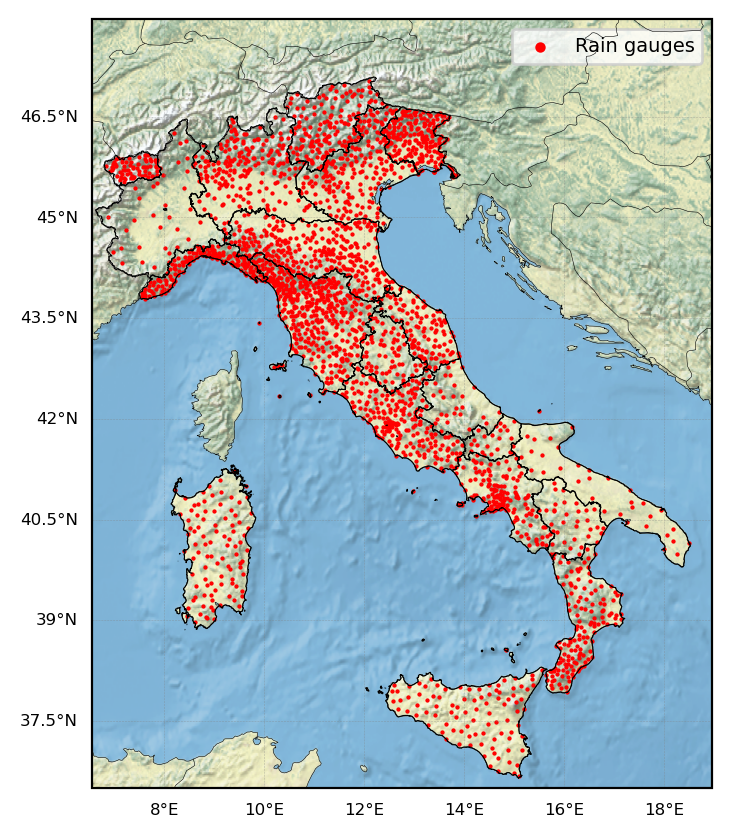

In [8]:
linewidth_map = 0.2

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,5),dpi=200)
gs = gridspec.GridSpec(1,1)

# ===========================================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.set_aspect('auto')
ax1.coastlines(linestyle='-',linewidth=linewidth_map,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS.with_scale('50m'),linewidth=linewidth_map,edgecolor='k',zorder=10)

show(naturalearth, ax=ax1)

REGIONS.plot(facecolor='None', ax=ax1, linewidth=0.4, zorder=10)

ax1.scatter(DF_IMERG['LON'], DF_IMERG['LAT'], c='r', s=0.3, label='Rain gauges')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

plt.legend(loc='upper right', fontsize=7, markerscale=5, frameon=True)

# ===========================================================================================================================================
salida = os.path.join('..','figures','Article_down','figure2.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

## Statistics

In [9]:
def obtener_estadisticas_estaciones(regions_gdf, station_lon, station_lat):
    """
    Calcula estadísticas de estaciones para cada región usando EPSG:3003 (Monte Mario/Italy zone 1)
    """
    
    # Crear GeoDataFrame con las estaciones
    estaciones_gdf = gpd.GeoDataFrame(
        geometry=[Point(lon, lat) for lon, lat in zip(station_lon, station_lat)],
        crs=regions_gdf.crs
    )
    
    # Realizar la unión espacial
    estaciones_en_regiones = gpd.sjoin(estaciones_gdf, regions_gdf, how='left', predicate='within')
    
    # CALCULAR ÁREA USANDO EPSG:3003 (Monte Mario/Italy zone 1)
    print(f"CRS original: {regions_gdf.crs}")
    
    try:
        regions_3003 = regions_gdf.to_crs('EPSG:3003')
        # Convertir a entero directamente
        regions_gdf['area_km2'] = (regions_3003.geometry.area / 1e6).astype(int)
        print("Áreas calculadas usando EPSG:3003 (Monte Mario/Italy zone 1)")
    except Exception as e:
        print(f"Error al convertir a EPSG:3003: {e}")
        try:
            regions_utm = regions_gdf.to_crs('EPSG:32632')
            regions_gdf['area_km2'] = (regions_utm.geometry.area / 1e6).astype(int)
            print("Áreas calculadas usando EPSG:32632 (UTM zone 32N)")
        except Exception as e2:
            print(f"Error al convertir a EPSG:32632: {e2}")
            regions_gdf['area_km2'] = (regions_gdf.geometry.area * 111 * 111).astype(int)
            print("Áreas calculadas usando aproximación geográfica")
    
    # Contar estaciones por región
    conteo_estaciones = estaciones_en_regiones.groupby('Region').size().reset_index(name='num_estaciones')
    
    # Unir con el GeoDataFrame original
    resultado = regions_gdf.merge(conteo_estaciones, on='Region', how='left')
    
    # Rellenar NaN con 0 para regiones sin estaciones y convertir a entero
    resultado['num_estaciones'] = resultado['num_estaciones'].fillna(0).astype(int)
    
    # Calcular densidad (estaciones por km²) y redondear
    resultado['densidad_estaciones_km2'] = (resultado['num_estaciones'] / resultado['area_km2']).round(4)
    
    # Calcular densidad por cada 1000 km² y redondear
    resultado['densidad_cada_1000km2'] = ((resultado['num_estaciones'] / resultado['area_km2']) * 1000).round(2)
    
    return resultado

In [10]:
resultado_final = obtener_estadisticas_estaciones(REGIONS, DF_IMERG['LON'].values, DF_IMERG['LAT'].values)

CRS original: EPSG:4326
Áreas calculadas usando EPSG:3003 (Monte Mario/Italy zone 1)


In [11]:
# resultado_print = resultado_final.drop(columns=["geometry"])
# resultado_print = resultado_print.drop(columns=["reg_istat_code_num"])
# resultado_print = resultado_print.drop(columns=["reg_istat_code"])

/home/arturo/anaconda3/envs/TEST/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/arturo/anaconda3/envs/TEST/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Export figure to: ../figures/Article_down/rainguage_density.png


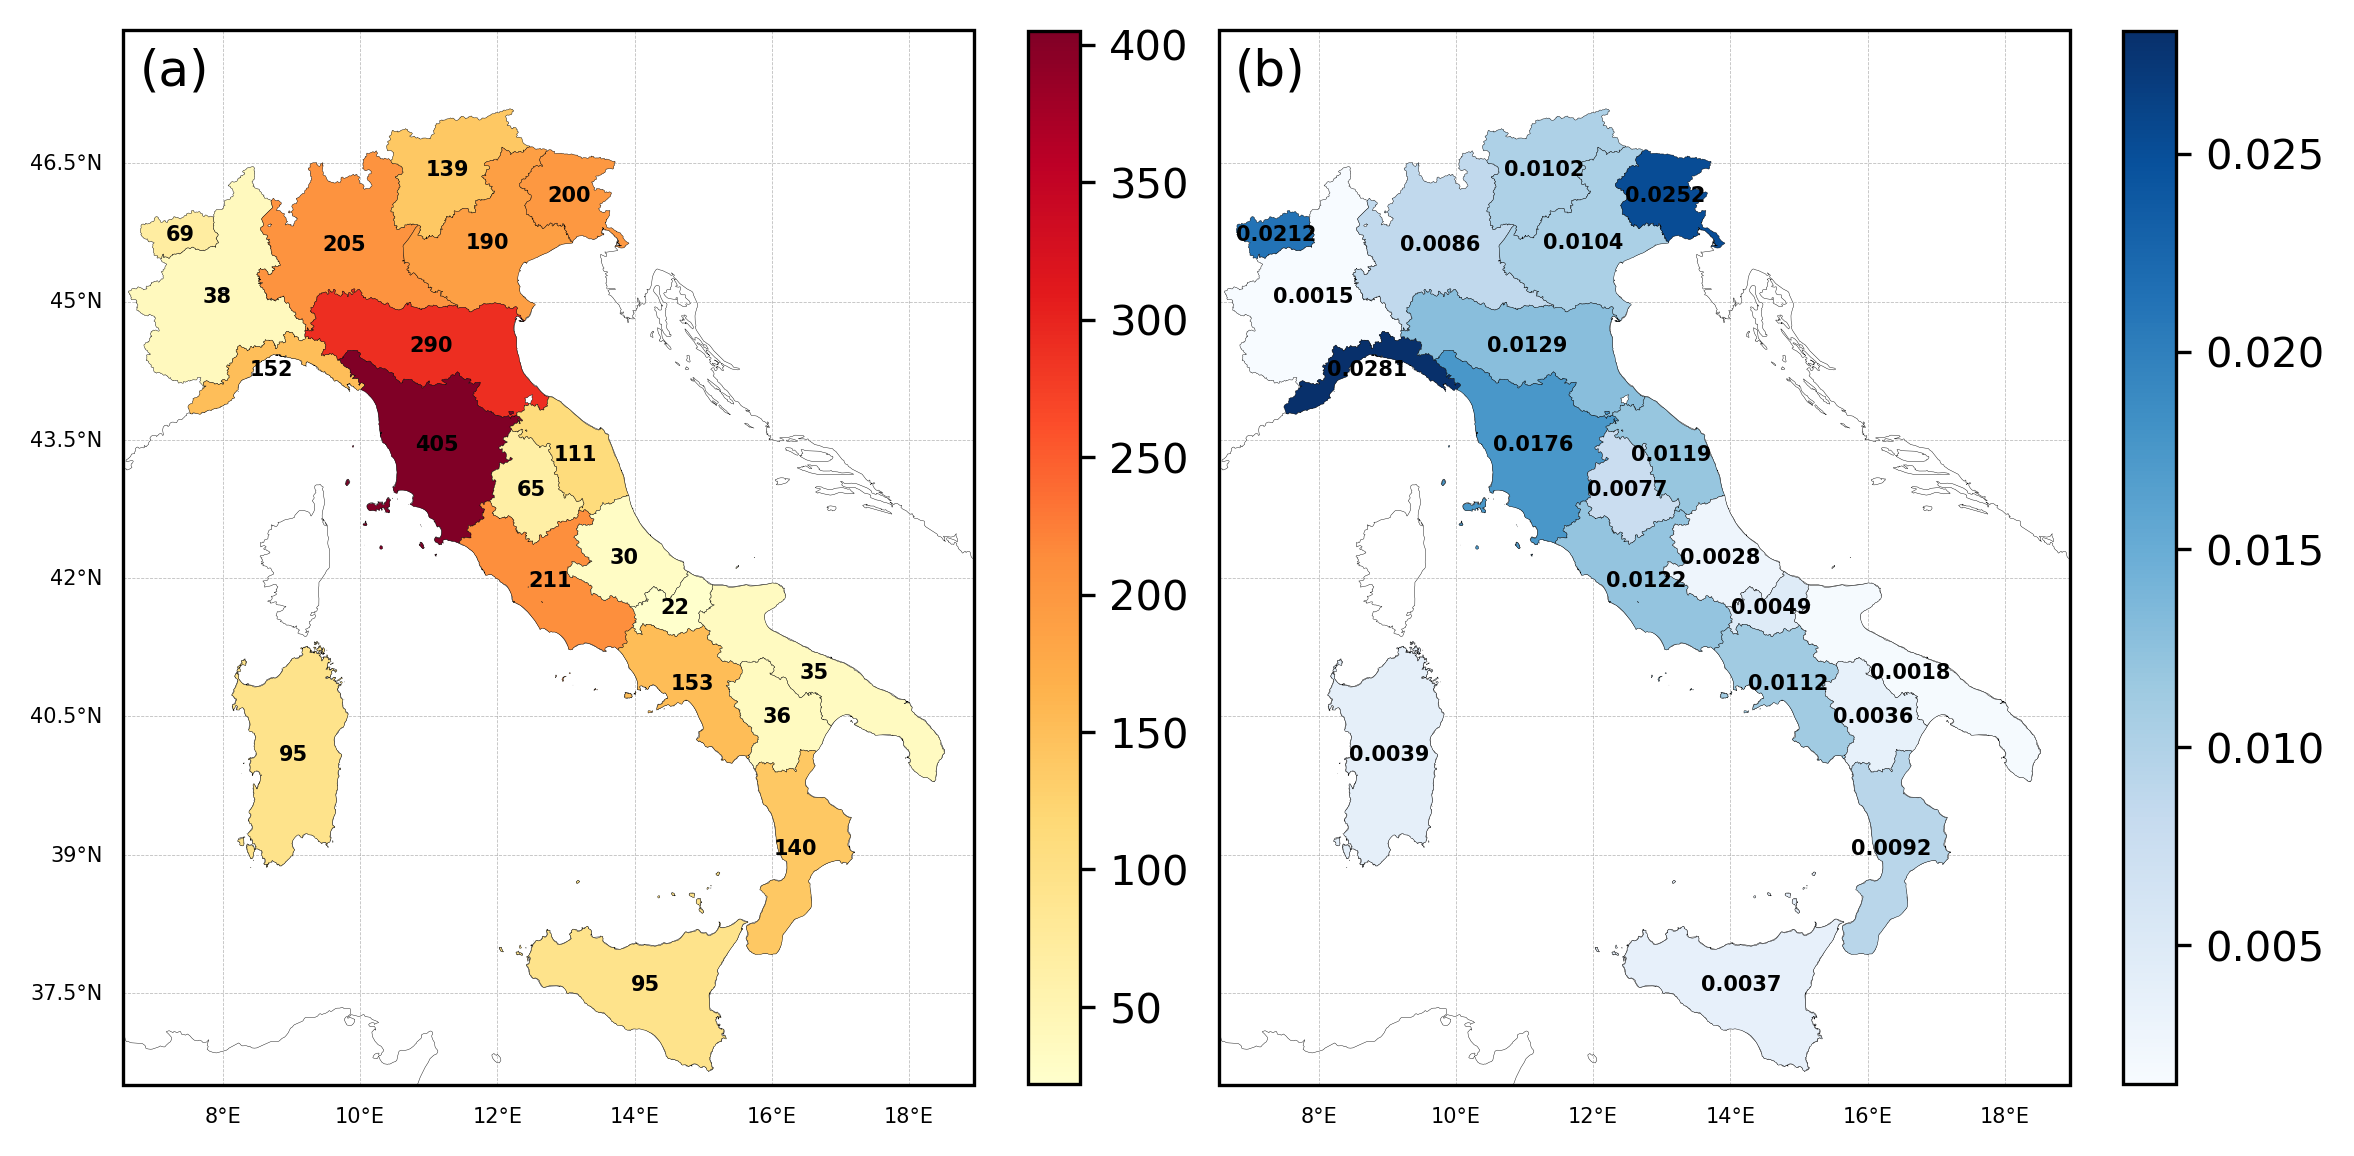

In [12]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,6), dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================================
ax1 = plt.subplot(gs[0, 0], projection=proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.1, color='k')

vmin = resultado_final['num_estaciones'].min()
vmax = resultado_final['num_estaciones'].max()

resultado_final.plot(column='num_estaciones',
                    ax=ax1,
                    cmap='YlOrRd',
                    linewidth=0.1,
                    edgecolor='black',
                    legend=True,
                    legend_kwds={
                        'shrink': 0.65,
                        'orientation': 'vertical'},
                    vmin=vmin, 
                    vmax=vmax,
                    zorder=11)

for idx, row in resultado_final.iterrows():
    centroid = row.geometry.centroid
    ax1.text(centroid.x, centroid.y, str(row['num_estaciones']), 
            fontsize=5, ha='center', va='center', weight='bold',
            transform=proj, zorder=20)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

ax1.text(7.3, 47.5, '(a)', 
            fontsize=12, ha='center', va='center',
            transform=proj, zorder=20)

# ==============================================================================================
ax1 = plt.subplot(gs[0, 1], projection=proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.1, color='k')

vmin = resultado_final['densidad_estaciones_km2'].min()
vmax = resultado_final['densidad_estaciones_km2'].max()

resultado_final.plot(column='densidad_estaciones_km2',
                    ax=ax1,
                    cmap='Blues',
                    linewidth=0.1,
                    edgecolor='black',
                    legend=True,
                    legend_kwds={
                        'shrink': 0.65,
                        'orientation': 'vertical'},
                    vmin=vmin, 
                    vmax=vmax,
                    zorder=11)

for idx, row in resultado_final.iterrows():
    centroid = row.geometry.centroid
    ax1.text(centroid.x, centroid.y, str(row['densidad_estaciones_km2']), 
            fontsize=5, ha='center', va='center', weight='bold',
            transform=proj, zorder=20)

ax1.text(7.3, 47.5, '(b)', 
            fontsize=12, ha='center', va='center',
            transform=proj, zorder=20)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

# ===========================================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.03, hspace=0.05)
salida = os.path.join('..','figures','Article_down','rainguage_density.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

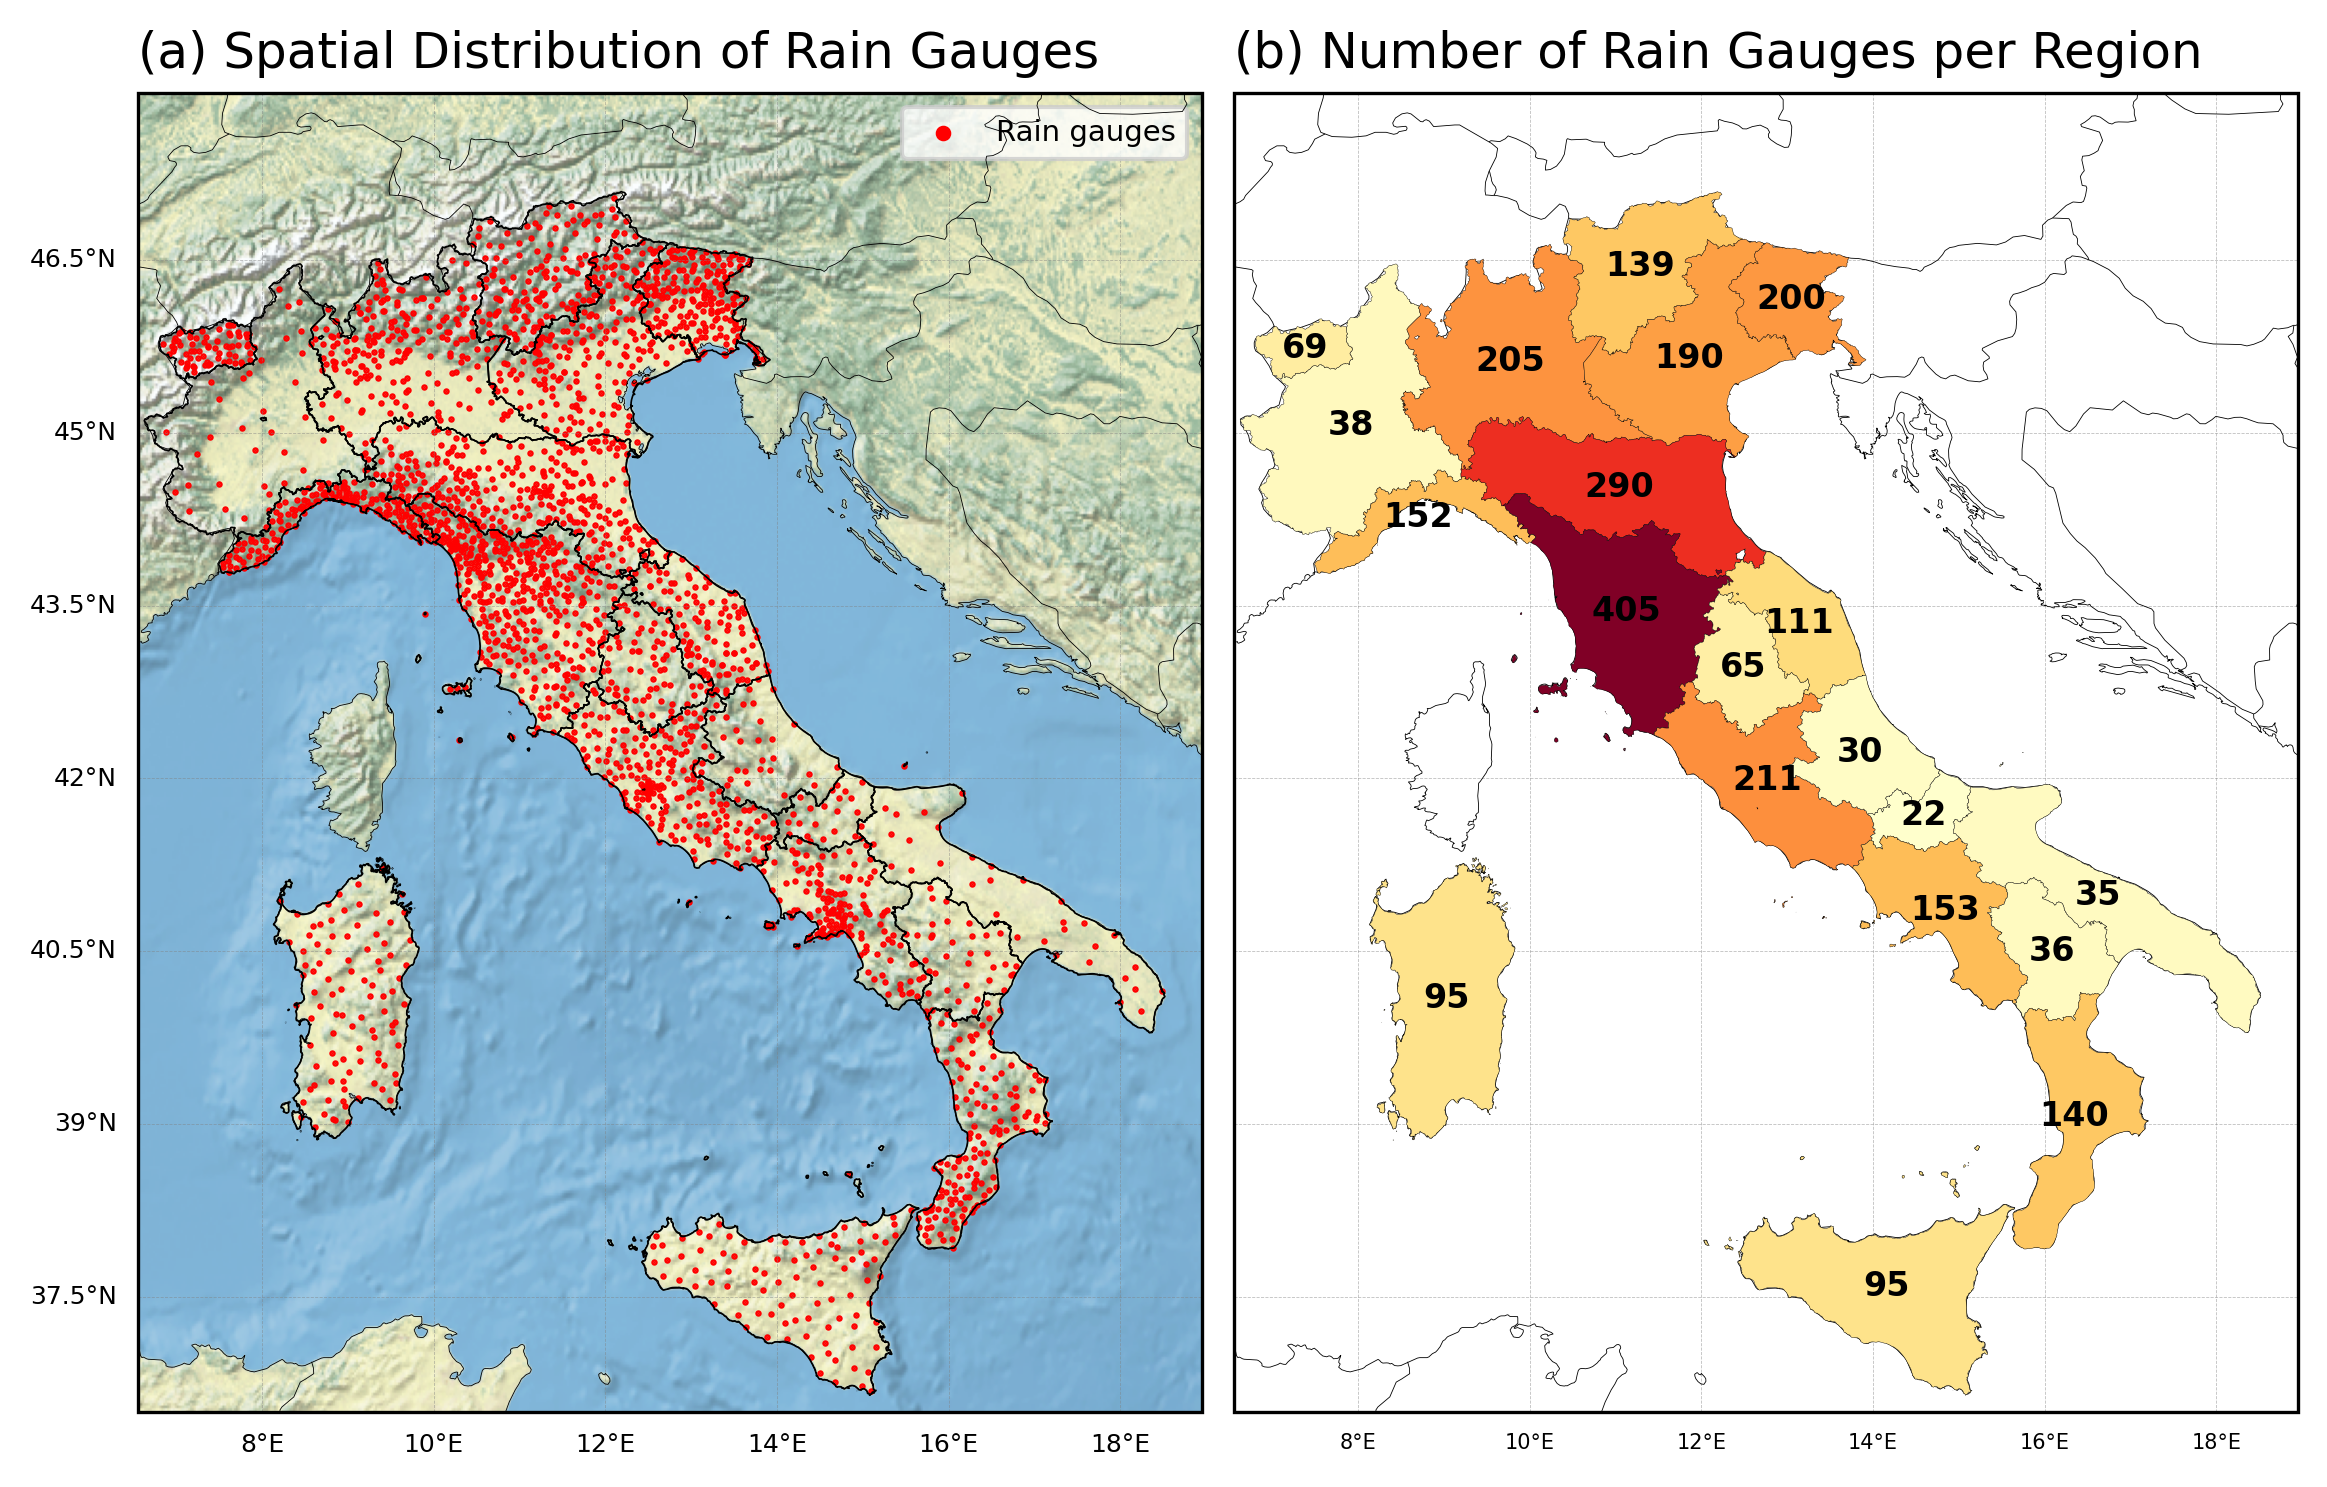

In [13]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,6), dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================================
ax1 = plt.subplot(gs[0, 0], projection=proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.coastlines(linestyle='-',linewidth=linewidth_map,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS.with_scale('50m'),linewidth=linewidth_map,edgecolor='k',zorder=10)

show(naturalearth, ax=ax1)

REGIONS.plot(facecolor='None', ax=ax1, linewidth=0.4, zorder=10)

ax1.scatter(DF_IMERG['LON'].values, DF_IMERG['LAT'].values, c='r', s=0.3, label='Rain gauges')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

plt.legend(loc='upper right', fontsize=7, markerscale=5, frameon=True)

ax1.set_title('(a) Spatial Distribution of Rain Gauges', fontsize=12, loc='left')

# ==============================================================================================
ax1 = plt.subplot(gs[0, 1], projection=proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.coastlines(linestyle='-',linewidth=linewidth_map,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS.with_scale('50m'),linewidth=linewidth_map,edgecolor='k',zorder=10)

vmin = resultado_final['num_estaciones'].min()
vmax = resultado_final['num_estaciones'].max()

resultado_final.plot(column='num_estaciones',
                    ax=ax1,
                    cmap='YlOrRd',
                    linewidth=0.1,
                    edgecolor='black',
                    legend=False,
                    legend_kwds={
                        'shrink': 0.65,
                        'orientation': 'vertical'},
                    vmin=vmin, 
                    vmax=vmax,
                    zorder=11)

for idx, row in resultado_final.iterrows():
    centroid = row.geometry.centroid
    ax1.text(centroid.x, centroid.y, str(row['num_estaciones']), 
            fontsize=8, ha='center', va='center', weight='bold',
            transform=proj, zorder=20)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

ax1.set_title('(b) Number of Rain Gauges per Region', fontsize=12, loc='left')

# ===========================================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.03, hspace=0.05)